<a href="https://colab.research.google.com/github/dzailz/MFoML/blob/main/%D0%9A%D0%B0%D1%82%D0%B8%D0%BD_%D0%92_%D0%92_%D0%9C%D0%9E%D0%9C%D0%9E_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_2_%D1%81%D0%B8%D0%BD%D1%82%D0%B5%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание на основе синтетических данных

## Импорты

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns 
sns.set() 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline 

from sklearn.preprocessing import PolynomialFeatures

## Генерация Данных

Создание одномерных данных, которые могут быть функциями некоторыми функциями от входных данных `X`.

Также добавим шумы к данным.

Т.о. есть мы будем иметь как истинный вариант зависимости, так и зашумленный.

Созданные данные могут быть как линейными, `f = None`, так и  гармоническими (`np.sin, np.cos`) или экспоненциальными `np.exp` (или можно задать свои функции)

In [ ]:
colors = ['r', 'g', 'c', 'y', 'm', 'b', 'w', 'k']

def true_fun(x, a=np.pi, b=0, f=np.sin):
    """
    Генерация произвольной зависимости
    Входные данные:

    :x: массив данных из которых будет генерироваться зависимость;
    :a: коэффициент на который входные данные будут умножаться
    если а - список, то это коэффициенты в полиномиальной зависимости
    так, а = [1,2,3] позволит сгенерировать зависимость вида 1 * x + 2 * x^2 + 3 * x^3;
    :b: коэффициент который будет добавлен к данным (постоянная добавка);
    :f: функция, которая будет применена к зависимости. Можно задать списком. Тогда это будут разные колонки.
    """
    x = np.atleast_1d(x)[:] # убеждаемся что данные - одномерный массив
    a = np.atleast_1d(a)
    
    if not f: 
        f = lambda x: x # если функция не задана (None), то ничего не происходит

    x = np.sum([ai * np.power(x, ind + 1) for ind, ai in enumerate(a)], axis=0) # до умножаем входные данные на коэффициенты (и если надо возводим в степень)

    return f(x + b)

def noises(shape, noise_power):
    """
    Генерация шума
    Входные данные:

    :shape: размерность массива данных;
    :noise_power: коэффициент ~ сила шума
    """
    return np.random.randn(*shape) * noise_power # библиотека numpy может генерировать случайные числа.
                                                # в данном случае - нормальное распределение (среднее = 0, стандартное отклонение = 1 )

def dataset(a, b, f=None,  N=250, x_max=1, noise_power=0, is_random_x=True,  seed=42):
    """Генерация набора данных
    Входные данные:

    :a: коэффициент на который будут умножаться входные данные
    Если "a" - список, то это говорит о полиномиальной зависимости
    например, а = [1, 2, 3] позволит сгенерировать зависимость вида 1 * x + 2 * x^2 + 3 * x^3;
    :b: коэффициент, который будет добавлен к данным (постоянная прибавка);
    :f: функция, которая будет применена к зависимости. Можно задать списком. Тогда это будут разные колонки;
    :N: количество точек данных;
    :x_max: максимальное значение данных;
    :noise_power: коэффициент ~ сила шума;
    :random_x: как будут распределены данные (линейно, или случайно);
    :seed: фиксированный сид случайных чисел (для повторяемости);
    """

    np.random.seed(seed) # фиксируем случайный seed
    
    # если мы хотим случайно распределить данные, то x будет N случайных чисел из диапазона от 0 до x_max
    # либо х это равномерно распределенные N чисел из диапазона от 0 до x_max
    x = (np.sort(np.random.rand(N)) * x_max) if is_random_x else np.linspace(0, x_max, N)

    y_true = np.array([]) # создаем пустой массив который будет "наполнять" зависимостями
    
    for f_ in np.append([], f): # если f - задана списком, то мы учтем все варианты
        y_true = np.append(y_true, true_fun(x, a, b, f_)) # применяем описанную выше функцию true_fun
    
    y_true = y_true.reshape(-1, N).T
    y = y_true + noises(y_true.shape, noise_power) # + шум

    return y, y_true, np.atleast_2d(x).T # возвращаем зашумленные значения зависимостей, зависимости без шума, и массив входных данных

Визуализация полученного набора данных:

In [ ]:
def vis_data(y, y_true, x, title):
    """Визуализация полученного набора данных  
    Входные данные:

    :y: зашумленные значения зависимостей;
    :y_true: зависимости без шума;
    :x: массив входных данных;
    :title: общий заголовок.
    """
    plt.figure(figsize=(15, 10))
    plt.scatter(
        x=x[:, 0], # какую переменную используем для горизонтальной оси - массив данных х
        y=y, # какую переменную используем для вертикальной оси - зашумленные значения зависимостей
        edgecolor='c', #  цвет маркера
        label="Зашумленные Данные", # название зависимости, которое будет отображено в легенде
        s=196, # квадрат радиуса
        alpha=0.6 # прозрачность
    )
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81, c='g', alpha = 0.8) # аналогично вышеописанному, только для зависимости без шума
                                                                                 # и с другими параметрами маркеров (цвет, размер, прозрачность, название)
    plt.grid() # чтобы была сетка
    plt.xlabel('x',fontsize=15) # название горизонтальной оси
    plt.ylabel('y',fontsize=15) # название вертикальной оси
    plt.legend(fontsize=10) # чтобы была легенда
    plt.title(title, fontsize=15 ) # заголовок
    plt.tight_layout() # чтобы полотно было без пустого пространство


Отрисовка модели, которая реализована через классы

In [ ]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    """
    Отрисовка модели которая реализована через классы.
    Входные данные:

    x_train: признаки на которых тренировались
    y_train: тренировочные целевые значения
    x_test: тестовые признаки
    x: полные признаки
    y: реальные целевые значения (без шума)
    model: обученная модель
    """
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=10); plt.grid()
    plt.xlabel('x',fontsize=15)
    plt.ylabel('y',fontsize=15)

## Линейная зависимость

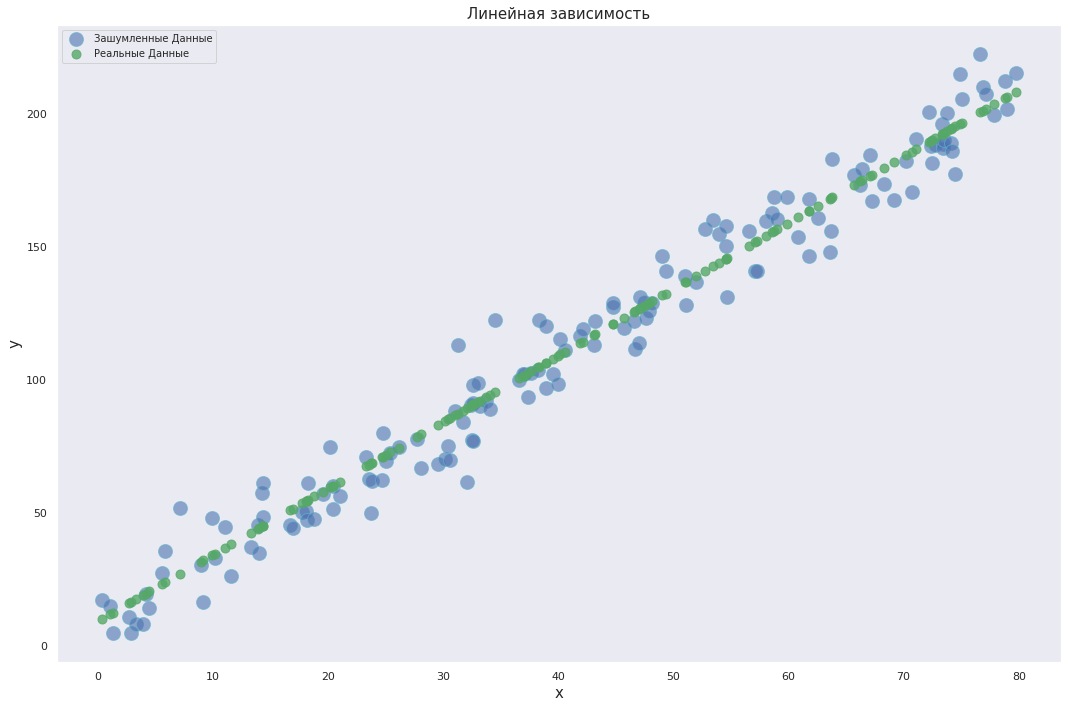

In [ ]:
y, y_true, x = dataset(
    a = 2.5,
    b = 9,
    f = None,
    N = 150,
    x_max = 80,
    noise_power = 10,
    seed = 50
)
vis_data(y, y_true, x, 'Линейная зависимость')

Класс **train_test_split** из пакета **sklearn** разбивает данные на тренировочную-валидационную-тестовую

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.3)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(105, 1) (45, 1) (105, 1) (45, 1)


Подготавливаем данные для обучения. Используем библиотеку **MinMaxScaler** из **sklearn** для нормализации данных, чтобы назначались адекватные веса вне зависимости от масштаба признаков.

In [ ]:
scaler = MinMaxScaler() # создаем экземпляр класса
scaler.fit_transform(x_train) # обучаем на тренировочных и сразу трансформируем
x_scaled = scaler.transform(x) 
x_train = scaler.transform(x_train) 
x_test  = scaler.transform(x_test)  # обучаем трансформируем тестовые данные

Применяем метод Линейной регрессии, и обучаем модель.

In [ ]:
LR = LinearRegression(fit_intercept=True) 
LR.fit(x_train, y_train)
y_predict = LR.predict(x_test)

### Кросс-валидация

In [ ]:
scoring = {
    'R2': 'r2',
    '-MSE': 'neg_mean_squared_error',
    '-MAE': 'neg_mean_absolute_error',
    'Max': 'max_error'
}


scores = cross_validate(
    LR,
    x_train,
    y_train,
    scoring=scoring,
    cv=ShuffleSplit(n_splits=5, random_state=42)
)

LR_cross = pd.DataFrame(scores) # Полученные данные оформляем в датафрейм
LR_mean = pd.DataFrame(LR_cross.mean()) # Средние значения оформляем в датафрейм
display(LR_cross.style.background_gradient(cmap='PuBu', axis=0))
print('\nMean cross-validation results')
display(LR_mean.transpose())

print(f'\nДиапазон значений y: {y.max() - y.min()}')

,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.093789,0.001868,0.959955,-96.936887,-8.689391,-15.737650
1,0.000894,0.001292,0.958606,-113.756943,-8.782463,-21.004442
2,0.000975,0.001372,0.971515,-135.397214,-9.219247,-27.146120
3,0.000763,0.001313,0.961178,-62.593218,-6.716342,-16.031777
4,0.000746,0.001397,0.972369,-111.906068,-7.110127,-27.263394



Mean cross-validation results


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.019433,0.001448,0.964724,-104.118066,-8.103514,-21.436677



Диапазон значений y: 218.11025851830686


### Оценка качества модели регрессии


In [ ]:
def metrics_func(y_test, y_predict):
    print(f"MSE: {mse(y_test, y_predict):.3f}\n"
          f"RMSE: {mse(y_test, y_predict, squared=False):.3f}\n"
          f"R2: {r2_score(y_test, y_predict):.3f}")

In [ ]:
metrics_func(y_test, y_predict)

MSE: 110.899
RMSE: 10.531
R2: 0.964


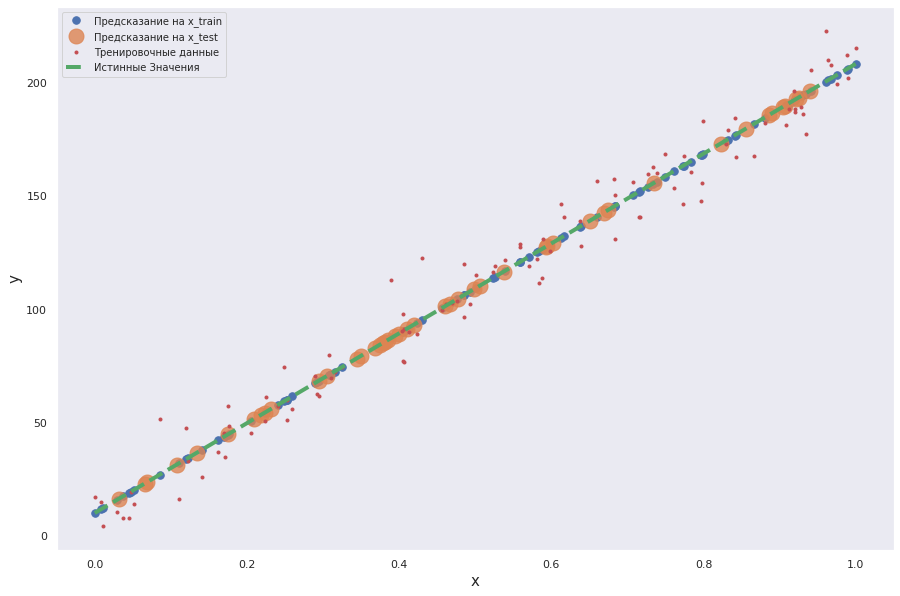

In [ ]:
fig  = plt.figure(figsize=(15,10))
plot_model_class(x_train, y_train,  x_test, x_scaled, y_true, LR)

Модель LinearRegression отработала с ошибками. Ошибка R2 = 0.964.

### L2 Регуляризация (Ridge)

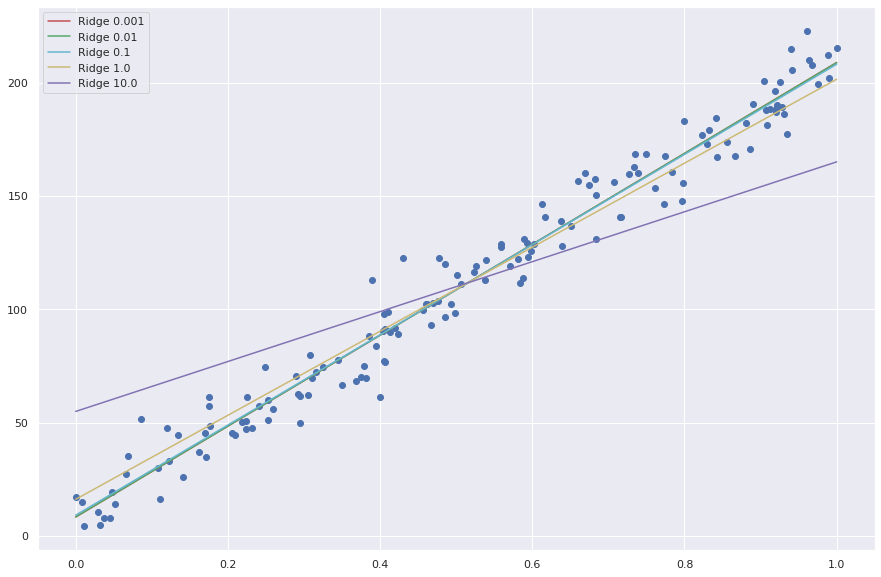

In [ ]:
fig  = plt.figure(figsize=(15,10))
l2 = 0.001
plt.scatter(x_scaled, y)
for i in range(5):
    val = l2 * 10 ** i
    reg_l2 = Ridge(alpha=val)
    reg_l2.fit(x_scaled, y)
    LR_predict = np.dot(x_scaled, reg_l2.coef_) + reg_l2.intercept_
    plt.plot(x_scaled, LR_predict, label=f'Ridge {val}', color=colors[i])
plt.legend();

Модель вполне точно работает с показателем регуляризации 0,1
Попробуем оценить данные с этим показателем.

In [ ]:
reg_l2 = Ridge(alpha = 0.1)
reg_l2.fit(x_train, y_train)
y_predict_l2 = reg_l2.predict(x_test)

metrics_func(y_test, y_predict_l2)

MSE: 114.404
RMSE: 10.696
R2: 0.963


Метрики не изменились (почти). Возможно, на новых данных предсказание будет лучше, но не с простой моделью.
Скорее всего регуляризация в данном случае без полезна.

In [ ]:
reg_l1 = linear_model.Lasso(alpha=0.0001, max_iter=10000)
reg_l1.fit(x_train, y_train)
y_predict_l1 = reg_l1.predict(x_test)

metrics_func(y_test, y_predict_l1)

MSE: 110.900
RMSE: 10.531
R2: 0.964


Регуляризация Лассо не привнесла почти ничего

## Полиномиальная зависимость

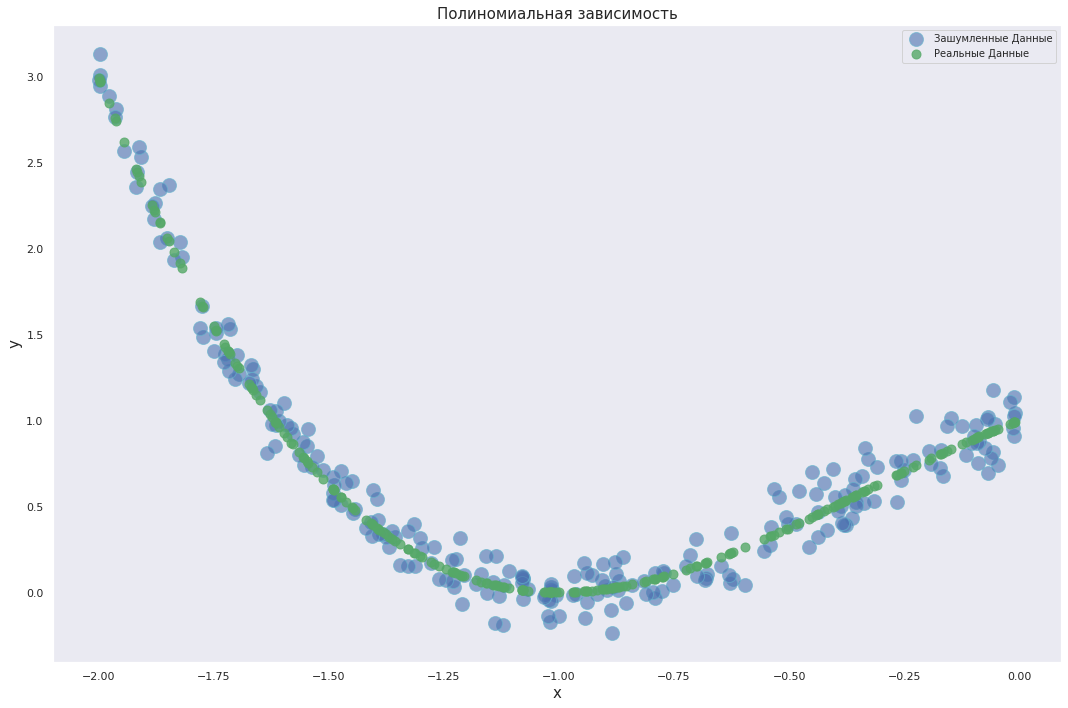

In [ ]:
y2, y_true2, x2 = dataset(
    a=[1,-1,-1],
    b=1,
    f=None,
    N=250,
    x_max=-2,
    noise_power=0.1,
    seed=22
)
vis_data(y2, y_true2, x2, 'Полиномиальная зависимость')

In [ ]:
# Деление на тренировочные тестовые данные
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.5, random_state=22) 

In [ ]:
# Применяем метод Линейной регрессии, и обучаем модель.
LR2 = LinearRegression() 
LR2.fit(x_train2, y_train2)
y_predict2 = LR2.predict(x_test2)

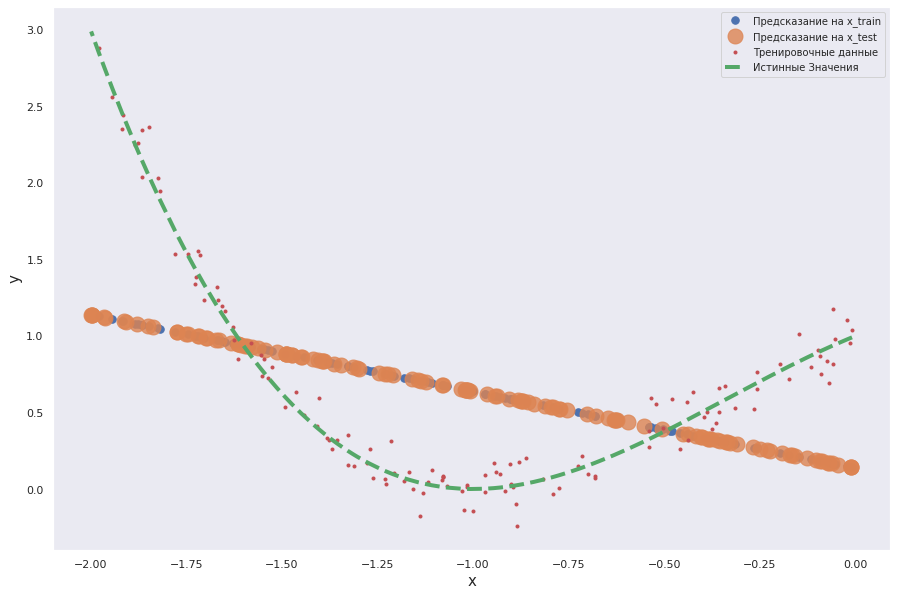

In [ ]:
# Визуализируем результат
fig  = plt.figure(figsize=(15,10))
plot_model_class(x_train2, y_train2,  x_test2, x2, y_true2, LR2)

Пробуем реализовать полиномиальную регрессию. 
Как известно члены полиномов различных целых степеней можно считать независимыми функциями. Поэтому 
регрессия может быть представлена как многопеременная линейная регрессия. 

Используем библиотеку 'Pipeline' из 'sklearn'

In [ ]:
# Выбор степени полиномов
pipe_poly = Pipeline([('poly', PolynomialFeatures(degree=4)), ('linear', LinearRegression(fit_intercept=False))])
pipe_poly.fit(x_train2, y_train2)
y_predict2 = pipe_poly.predict(x_test2)

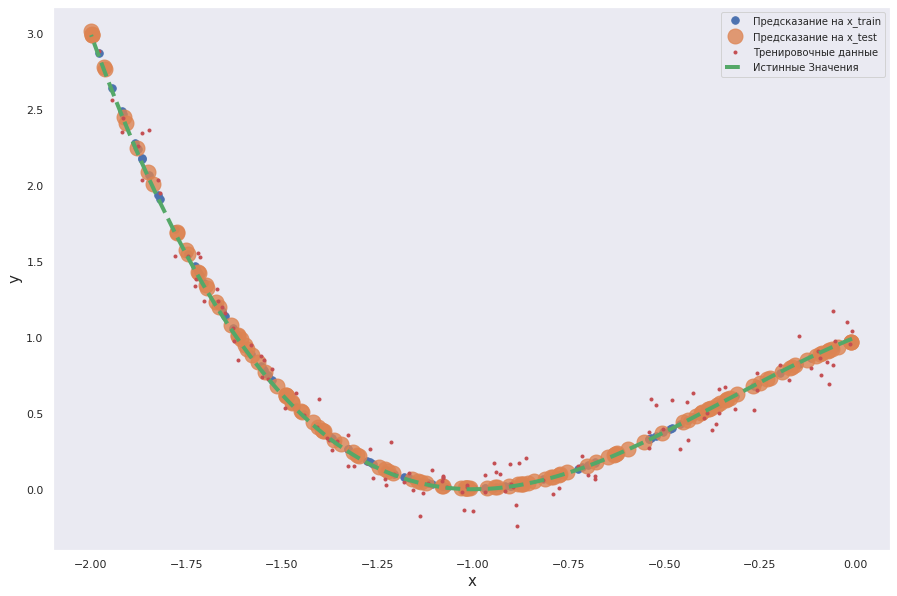

In [ ]:
# Отрисовываем результат и сравниваем с исходными данными
fig  = plt.figure(figsize=(15,10))
plot_model_class(x_train2, y_train2,  x_test2, x2, y_true2, pipe_poly)

In [ ]:
# Проверим метрики
metrics_func(y_test2, y_predict2)

print(f'Оценка модели: {pipe_poly.score(x_train2, y_train2)}')

MSE: 0.012
RMSE: 0.108
R2: 0.979
Оценка модели: 0.9748468073129127


### Подбор степени полиномов

Пробуем повышать степень полиномов

,Polynomial degree,Test Error,Train Error,Difference
0,1,0.443829,0.376367,0.067462
1,2,0.038263,0.033168,0.005095
2,3,0.011623,0.011527,0.000096
3,4,0.011579,0.011520,0.000059
4,5,0.012486,0.011398,0.001087
5,6,0.012385,0.011364,0.001022
6,7,0.012646,0.011296,0.001350
7,8,0.012674,0.011296,0.001378
8,9,0.012675,0.011296,0.001379
9,10,0.012721,0.011294,0.001427


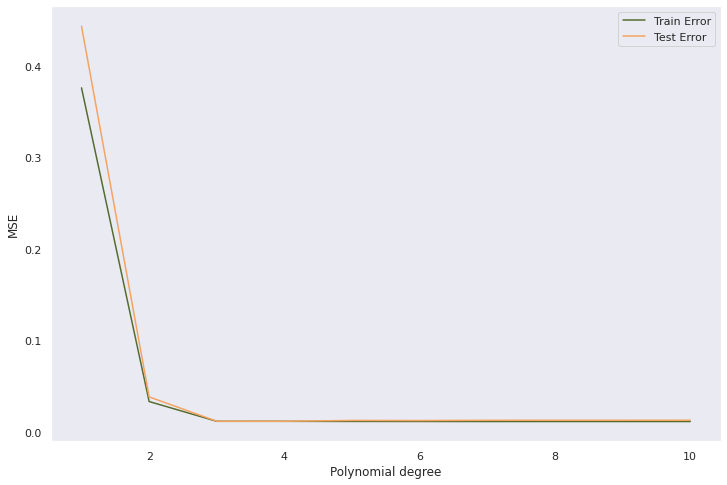

In [ ]:
poly_num = 10 # Выбираем максимальное количество полиномов для проверки
err_train = np.zeros(poly_num)
err_test = np.zeros(poly_num)
err_diff =  np.zeros(poly_num) # Создаем пустые массивы
for i in range(0, poly_num):
    err_model = make_pipeline(PolynomialFeatures(i+1), LinearRegression()) # Используем сокращенный конструктор пайплайна
    err_model.fit(x_train2, y_train2)
    err_train[i] = mse(y_train2, err_model.predict(x_train2)) # Предсказываем по тренировочной выборке
    err_test[i] = mse(y_test2, err_model.predict(x_test2)) # Предсказываем по тестовой выборке
    err_diff[i] = abs(err_train[i] - err_test[i]) # Сравниваем выборки

err_list = ['Test Error', 'Train Error', 'Difference']
d = {err_list[0]: err_test, err_list[1]: err_train, err_list[2]:err_diff}
err_df = pd.DataFrame(d) # Оформляем массивы в датафрейм на основе словаря
err_df.insert(0, 'Polynomial degree', err_df.index.values+1)
display(err_df.style.background_gradient(cmap='YlGn', vmin=0, vmax=.004, axis=0, subset=[err_list[0], err_list[1], err_list[2]]))

plt.figure(figsize=(12,8))
plt.plot(err_df['Polynomial degree'], err_train, color='darkolivegreen', label=err_list[1])
plt.plot(err_df['Polynomial degree'], err_test, color='sandybrown', label=err_list[0])
plt.grid()
plt.ylabel('MSE')
plt.xlabel('Polynomial degree')
plt.legend(loc='upper right');

Как видно из данных нет смысла использовать больше 3 полиномов

### L1 Регуляризация (Lasso)

In [ ]:
poly_reg_l1 = make_pipeline(PolynomialFeatures(degree=3), Lasso(alpha=0.005))
poly_reg_l1.fit(x_train2, y_train2)
y_predict_poly = poly_reg_l1.predict(x_test2)

In [ ]:
# Посмотрим как изменились метрики
metrics_func(y_test2, y_predict_poly)

MSE: 0.016
RMSE: 0.126
R2: 0.971


Показатели были практически идеальны, так что, L1 регуляризация лишь слегка ухудшила их.

### Эластичная регуляризация

Эластичная регуляризация использует как L1, так и L2 регуляризации, учитывая эффективность обоих методов. 

In [ ]:
reg_l1l2 = make_pipeline(PolynomialFeatures(degree=4), ElasticNetCV(cv=2, random_state=22))
reg_l1l2.fit(x_train2, y_train2[:,0])
y_predict_er = reg_l1l2.predict(x_test2)

In [ ]:
# Выполняем метрики
metrics_func(y_test2, y_predict_er)

MSE: 0.015
RMSE: 0.122
R2: 0.973


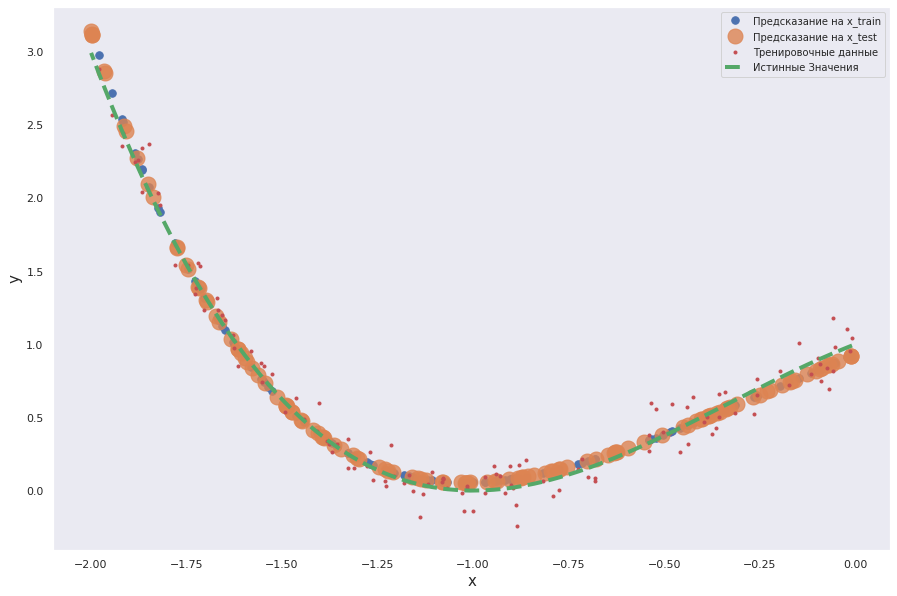

In [ ]:
# Отрисовываем результат и сравниваем с исходными данными
fig  = plt.figure(figsize=(15,10))
plot_model_class(x_train2, y_train2,  x_test2, x2, y_true2, reg_l1l2)

Выходные данные практически не изменились, незначительно ухудшившись

## Гармоническая зависимость

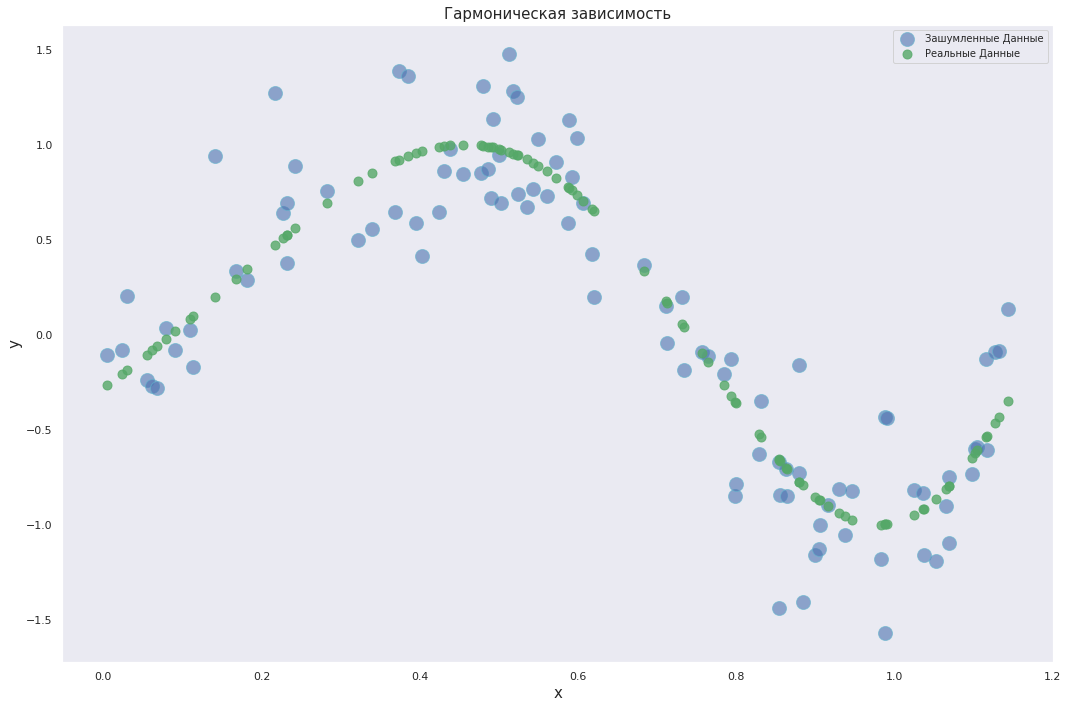

In [ ]:
y3, y_true3, x3 = dataset(
    a=[np.pi, 2],
    b=6,
    f=np.sin,
    N=100,
    x_max=1.15,
    noise_power=0.3,
    seed=52
)
vis_data(y3, y_true3, x3, 'Гармоническая зависимость')

In [ ]:
x_train3, x_test3, y_train3, y_test3= train_test_split(x3, y3, test_size=0.3, random_state=22) 

In [ ]:
# Применяем метод Линейной регрессии, и обучаем модель.
LR3 = LinearRegression() 
LR3.fit(x_train3, y_train3)
y_predict3 = LR3.predict(x_test3)

Ошибка на тренировочных данных = 0.346


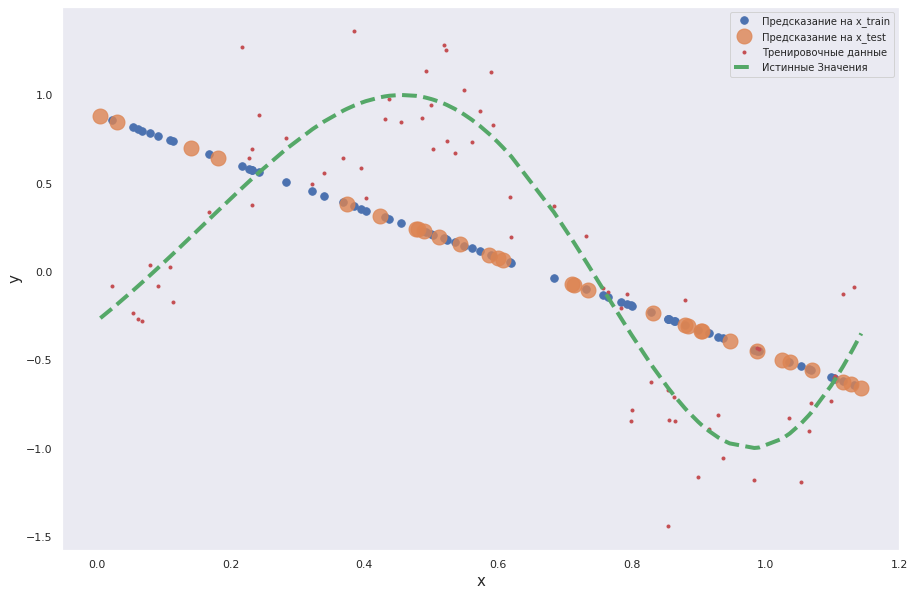

In [ ]:
#Визуализируем результат
fig  = plt.figure(figsize=(15,10))
plot_model_class(x_train3, y_train3,  x_test3, x3, y_true3, LR3)
print(f'Ошибка на тренировочных данных = {LR3.score(x_train3, y_train3):.3f}')

Простая модель не справляется даже близко. Пробуем использовать полиномы.
Пойдем по проторенной дорожке и попробуем найти количество полиномов для наиболее эффективного применения

,Polynomial degree,Test Error,Train Error,Difference
0,1,0.457701,0.363691,0.094010
1,2,0.378214,0.236646,0.141569
2,3,0.196666,0.107589,0.089078
3,4,0.101107,0.076618,0.024489
4,5,0.100686,0.076513,0.024173
5,6,0.108748,0.075552,0.033196
6,7,0.108046,0.074680,0.033365
7,8,0.110873,0.062837,0.048036
8,9,0.110397,0.062628,0.047769
9,10,0.115885,0.062485,0.053400


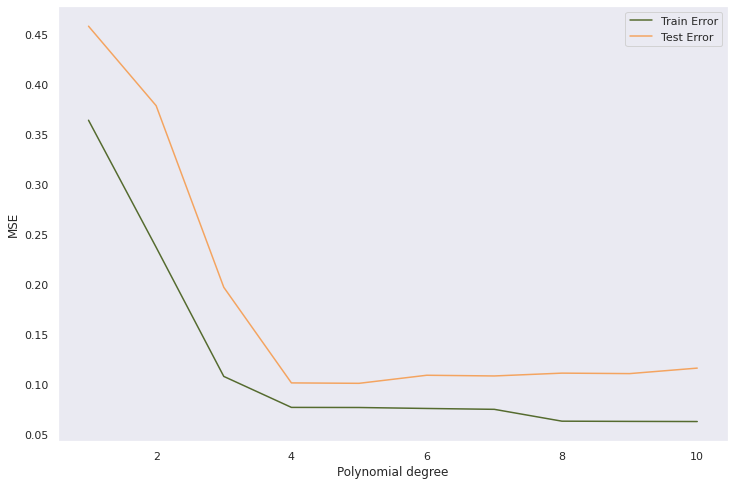

In [ ]:
poly_num3 = 10 # Выбираем максимальное количество полиномов для проверки
err_train = np.zeros(poly_num3)
err_test = np.zeros(poly_num3)
err_diff =  np.zeros(poly_num3) # Создаем пустые массивы
for i in range(0, poly_num3):
    err_model = make_pipeline(PolynomialFeatures(i+1), LinearRegression()) # Используем сокращенный конструктор пайплайна
    err_model.fit(x_train3, y_train3)
    err_train[i] = mse(y_train3, err_model.predict(x_train3)) # Предсказываем по тренировочной выборке
    err_test[i] = mse(y_test3, err_model.predict(x_test3)) # Предсказываем по тестовой выборке
    err_diff[i] = abs(err_train[i] - err_test[i]) # Сравниваем выборки

err_list = ['Test Error', 'Train Error', 'Difference']
d = {err_list[0]: err_test, err_list[1]: err_train, err_list[2]:err_diff}
err_df = pd.DataFrame(d) # Оформляем массивы в датафрейм на основе словаря
err_df.insert(0, 'Polynomial degree', err_df.index.values+1)
display(err_df.style.background_gradient(cmap='YlGn', vmin=0, vmax=.02, axis=0, subset=[err_list[0], err_list[1], err_list[2]]))

plt.figure(figsize=(12,8))
plt.plot(err_df['Polynomial degree'], err_train, color='darkolivegreen', label=err_list[1])
plt.plot(err_df['Polynomial degree'], err_test, color='sandybrown', label=err_list[0])
plt.grid()
plt.ylabel('MSE')
plt.xlabel('Polynomial degree')
plt.legend(loc='upper right');

Лучшие данные показывают 4 полиномов

In [ ]:
# выбор степени полиномов
pipe_poly3 = Pipeline([('poly', PolynomialFeatures(degree=4)), ('linear', LinearRegression(fit_intercept=False))])
pipe_poly3.fit(x_train3, y_train3)
y_predict3 = pipe_poly3.predict(x_test3)

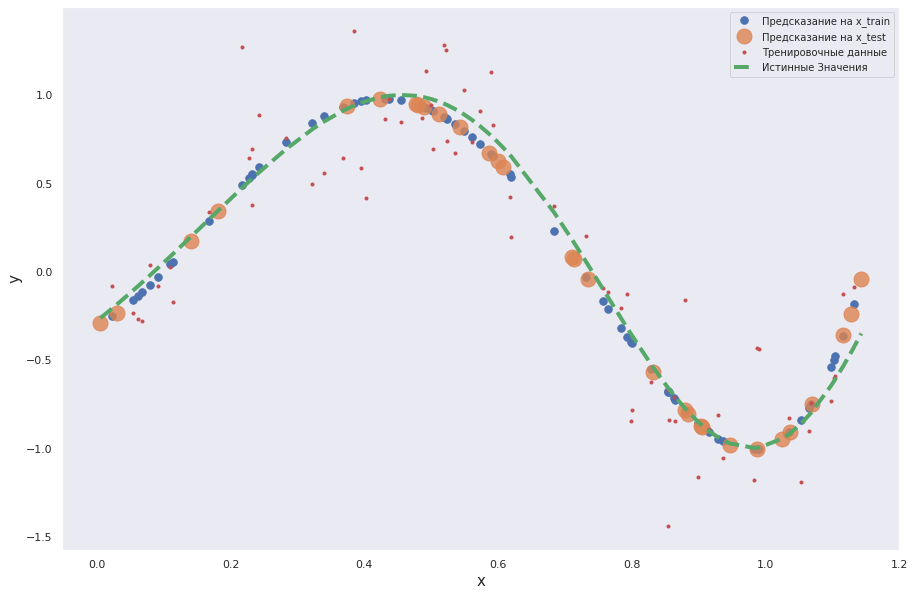

In [ ]:
# Отрисовываем результат и сравниваем с исходными данными
fig  = plt.figure(figsize=(15,10))
plot_model_class(x_train3, y_train3,  x_test3, x3, y_true3, pipe_poly3)

In [ ]:
# Выполняем метрики
metrics_func(y_test3, y_predict3)

MSE: 0.101
RMSE: 0.318
R2: 0.866


Модель дает нормальный результат. Попробуем улучшить с помощью регуляризации L2.

### L2 Регуляризация (Ridge)

In [ ]:
l2_reg3 = make_pipeline(PolynomialFeatures(degree=5), Ridge(alpha=0.001))
l2_reg3.fit(x_train3, y_train3)
y_l2_predict3 = l2_reg3.predict(x_test3)

In [ ]:
metrics_func(y_test3, y_l2_predict3)

MSE: 0.107
RMSE: 0.327
R2: 0.858


К сожалению улучшить данные не удалось

### Гармоническая зависимость №2

Попробуем создать еще одну модель на основе гармонической зависимости на основе экспоненциальной функции.

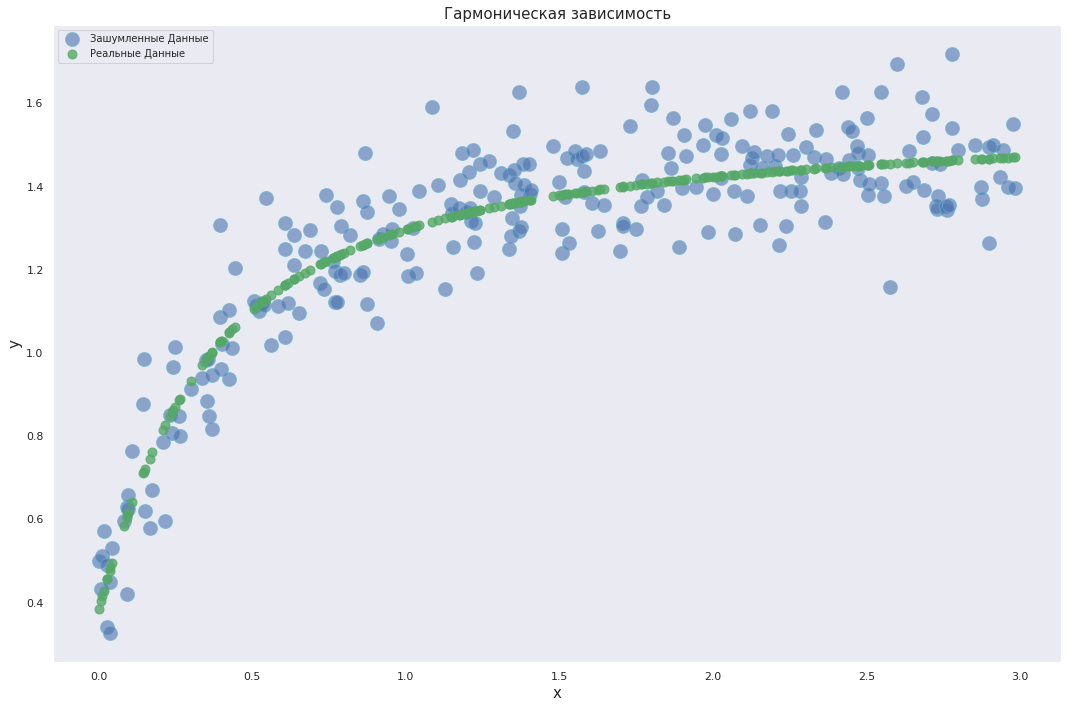

In [ ]:
y4, y_true4, x4 = dataset(
    a=np.pi,
    b=0.4,
    f=np.arctan,
    N=255,
    x_max=3,
    noise_power=0.1,
    seed=40
)
vis_data(y4, y_true4, x4,  'Гармоническая зависимость')

In [ ]:
x_train4, x_test4, y_train4, y_test4 = train_test_split(x4, y4, test_size=0.3, random_state=22) 

In [ ]:
# Применяем метод Линейной регрессии, и обучаем модель.
LR4 = LinearRegression() 
LR4.fit(x_train4, y_train4)
y_predict4 = LR4.predict(x_test4)

Ошибка на тренировочных данных = 0.346


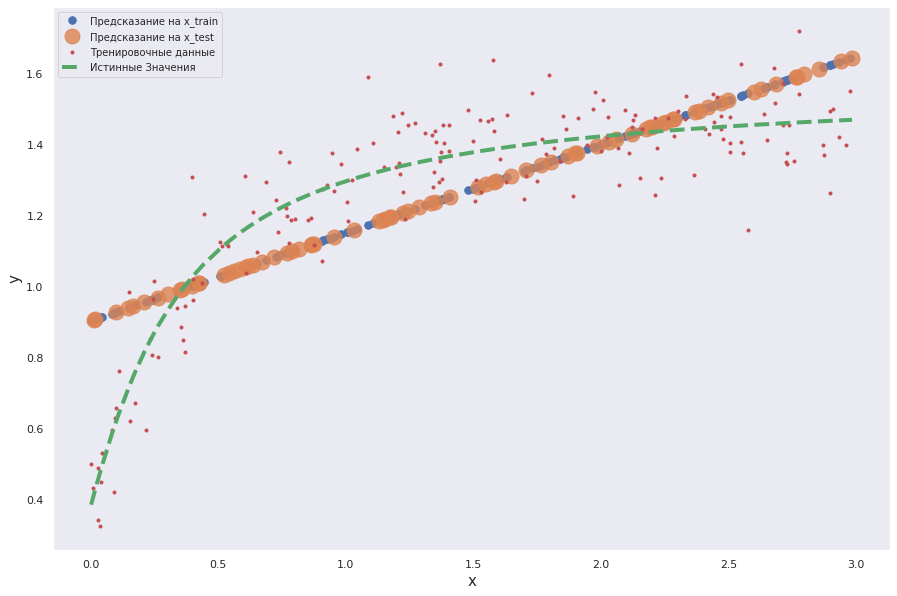

In [ ]:
# Визуализируем результат
fig  = plt.figure(figsize=(15,10))
plot_model_class(x_train4, y_train4,  x_test4, x4, y_true4, LR4)
print(f'Ошибка на тренировочных данных = {LR3.score(x_train3, y_train3):.3f}')

Используем полиномы.

,Polynomial degree,Test Error,Train Error,Difference
0,1,0.027327,0.034373,0.007046
1,2,0.013140,0.014958,0.001818
2,3,0.011096,0.010931,0.000165
3,4,0.009848,0.010363,0.000515
4,5,0.009732,0.010290,0.000558
5,6,0.010134,0.010165,0.000031
6,7,0.010207,0.010153,0.000054
7,8,0.010138,0.010124,0.000014
8,9,0.010146,0.010122,0.000024
9,10,0.010228,0.010108,0.000120


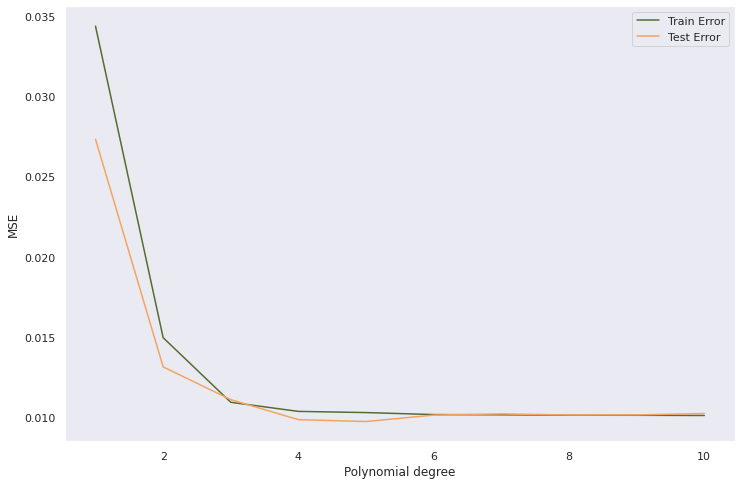

In [ ]:
poly_num4 = 10 # Выбираем максимальное количество полиномов для проверки
err_train = np.zeros(poly_num4)
err_test = np.zeros(poly_num4)
err_diff =  np.zeros(poly_num4) # Создаем пустые массивы
for i in range(0, poly_num4):
    err_model = make_pipeline(PolynomialFeatures(i+1), LinearRegression()) # Используем сокращенный конструктор пайплайна
    err_model.fit(x_train4, y_train4)
    err_train[i] = mse(y_train4, err_model.predict(x_train4)) # Предсказываем по тренировочной выборке
    err_test[i] = mse(y_test4, err_model.predict(x_test4)) # Предсказываем по тестовой выборке
    err_diff[i] = abs(err_train[i] - err_test[i]) # Сравниваем выборки

err_list = ['Test Error', 'Train Error', 'Difference']
d = {err_list[0]: err_test, err_list[1]: err_train, err_list[2]:err_diff}
err_df = pd.DataFrame(d) # Оформляем массивы в датафрейм на основе словаря
err_df.insert(0, 'Polynomial degree', err_df.index.values+1)
display(err_df.style.background_gradient(cmap='YlGn', vmin=0, vmax=.008, axis=0, subset=[err_list[0], err_list[1], err_list[2]]))

plt.figure(figsize=(12,8))
plt.plot(err_df['Polynomial degree'], err_train, color='darkolivegreen', label=err_list[1])
plt.plot(err_df['Polynomial degree'], err_test, color='sandybrown', label=err_list[0])
plt.grid()
plt.ylabel('MSE')
plt.xlabel('Polynomial degree')
plt.legend(loc='upper right');

Наилучший результат дают 5 полиномов

In [ ]:
# выбор степени полиномов
pipe_poly4 = Pipeline([('poly', PolynomialFeatures(degree=5)), ('linear', LinearRegression(fit_intercept=False))])
pipe_poly4.fit(x_train4, y_train4)
y_predict4 = pipe_poly4.predict(x_test4)

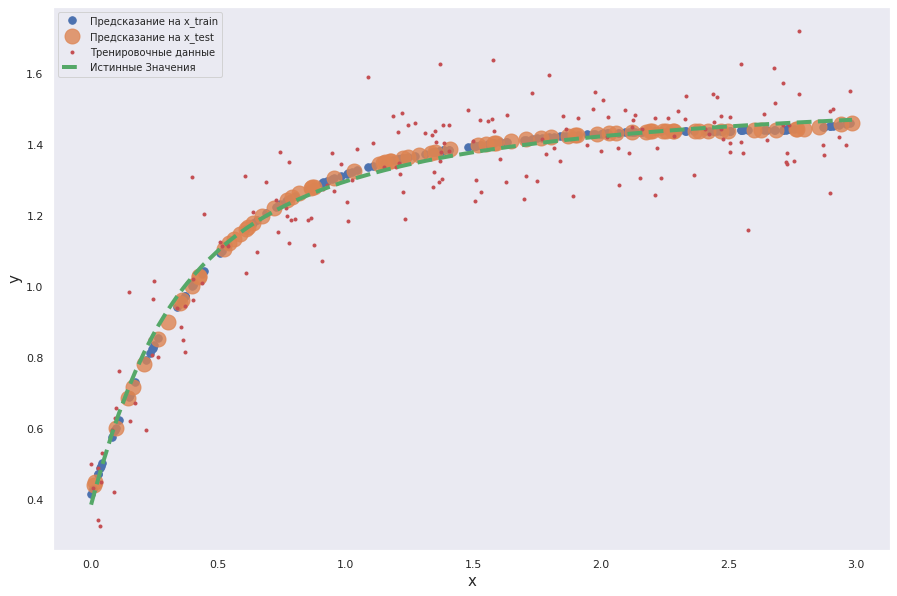

In [ ]:
# Отрисовываем результат и сравниваем с исходными данными
fig  = plt.figure(figsize=(15,10))
plot_model_class(x_train4, y_train4,  x_test4, x4, y_true4, pipe_poly4)

In [ ]:
# Выполняем метрики
metrics_func(y_test4, y_predict4)

MSE: 0.010
RMSE: 0.099
R2: 0.851


### L2 Регуляризация (Ridge)

In [ ]:
l2_reg4 = make_pipeline(PolynomialFeatures(degree=4), Ridge(alpha=.001))
l2_reg4.fit(x_train4, y_train4)
y_l2_predict4 = l2_reg4.predict(x_test4)

In [ ]:
metrics_func(y_test4, y_l2_predict4)

MSE: 0.010
RMSE: 0.099
R2: 0.849


После L2 регуляризации результат почти не изменился.

### L1 Регуляризация (Lasso)

In [ ]:
l1_reg_4 = make_pipeline(PolynomialFeatures(degree=4), Lasso(alpha=0.000005, max_iter=100000))
l1_reg_4.fit(x_train4, y_train4)
y_predict_reg4 = l1_reg_4.predict(x_test4)

In [ ]:
# Посмотрим как изменились метрики
metrics_func(y_test4, y_predict_reg4)

MSE: 0.010
RMSE: 0.099
R2: 0.849


 Не удалось добиться значимых различий L1 регуляризация не требуется